# **Imports**

In [1]:
!pip install -q tensorflow-io


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_io as tfio

import librosa
from PIL import Image

In [3]:
print("Tensorflow version ", tf. __version__)

Tensorflow version  2.10.0


# **Dataset**

In [4]:
# output directory where the spectrograms will be stored
spectrogram_dir = os.path.join("../src/", "speech_commands_v2_spectrograms")

## **Dataset Donwload**

In [ ]:
dataset_version = 2
base_dir = os.path.join("data", f"speech_commands_v{dataset_version}")
data_dir = os.path.join(base_dir, "train")

if not os.path.isdir(data_dir):
  tf.keras.utils.get_file(
      'speech_commands.tar.gz',
      origin=f"http://download.tensorflow.org/data/speech_commands_v0.0{dataset_version}.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir=data_dir
  )

In [ ]:
shutil.rmtree(os.path.join(data_dir,"_background_noise_"), ignore_errors=True)

In [ ]:
# CREATE VALIDATION FOLDER
val_dir = os.path.join(base_dir, "val")
if not os.path.isdir(val_dir):
    validationlist_file = open(os.path.join(data_dir, "validation_list.txt"), "r")
    validationlist = validationlist_file.readlines()

    os.makedirs(val_dir, exist_ok=True)

    for fname in validationlist:
        fname = fname.strip()
        category, filename = fname.split("/")

        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        shutil.move(os.path.join(data_dir, fname), os.path.join(val_dir, fname))

In [ ]:
# CREATE TEST FOLDER
test_dir = os.path.join(base_dir, "test")
if not os.path.isdir(test_dir):
    testlist_file = open(os.path.join(data_dir, "testing_list.txt"), "r")
    testlist = testlist_file.readlines()

    os.makedirs(test_dir, exist_ok=True)

    for fname in testlist:
        fname = fname.strip()
        category, filename = fname.split("/")

        os.makedirs(os.path.join(test_dir, category), exist_ok=True)
        shutil.move(os.path.join(data_dir, fname), os.path.join(test_dir, fname))

# **Generate Spectrogram Images**

## **Variables and Functions**

In [ ]:
SAMPLE_RATE = 16000

# spectrogram setting
SPEC_FRAME_SIZE = int(SAMPLE_RATE*0.025)
SPEC_HOP_SIZE =  int(SAMPLE_RATE*0.010)
SPEC_WINDOW = "hamming"
# SPEC_WINDOW = "hann"
SPEC_FMIN = 0
MELS = 128

In [ ]:
def plot_spectrogram(spectrogram, transpose=False, cmap=None):
    if transpose:
        spectrogram = spectrogram.T
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    # X = list(range(spectrogram.shape[1]))
    Y = range(height)
    plt.pcolormesh(X, Y, spectrogram, cmap=cmap) 
    plt.show()

In [ ]:
def mel_spectrogram(y, sr, n_mels, n_fft, hop_length, fmin=0.0, window="hamming"):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels = n_mels, n_fft=n_fft, hop_length=hop_length, fmin=fmin, window=window)
    log_mel_spec = np.log(mel_spec + 1e-07)
    return log_mel_spec

In [ ]:
def pad_to_1_sec(audio, sr):
    samples = len(audio)
    len_to_pad = sr - samples
    if len_to_pad > 0:
        audio = np.pad(audio, (0, len_to_pad), 'constant')

    return audio

In [ ]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [ ]:
def spectrogram_image(spectrogram):
    # min-max scale to fit inside 8-bit range
    img = scale_minmax(spectrogram, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    return img

In [ ]:
def save_img(spec, filename):
    img = Image.fromarray(spec, 'L')    # L = grayscale mode
    img.save(filename)

## **Sample**

mel shape: (128, 101)
spec img shape: (128, 101)


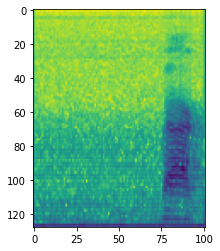

In [ ]:
file_path= os.path.join(data_dir, "backward/0165e0e8_nohash_0.wav")

audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
audio = pad_to_1_sec(audio, sr)
mel_spec = mel_spectrogram(y=audio, sr=sr, n_mels=MELS, n_fft=SPEC_FRAME_SIZE, hop_length=SPEC_HOP_SIZE, fmin=SPEC_FMIN, window=SPEC_WINDOW)
print("mel shape:", mel_spec.shape)

img = spectrogram_image(mel_spec)
print("spec img shape:", img.shape)


img = Image.fromarray(img, 'L')

plt.imshow(img)

## **Generate Spectrograms**

In [ ]:
from multiprocessing import Pool

In [ ]:
def convert_to_spectrogram(file_path):
    parts = file_path.split("/")
    label = parts[-2]
    train_test_val_folder = parts[-3]
    basename = os.path.splitext(parts[-1])[0]

    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    audio = pad_to_1_sec(audio, sr)
    mel_spec = mel_spectrogram(y=audio, sr=sr, n_mels=MELS, n_fft=SPEC_FRAME_SIZE, hop_length=SPEC_HOP_SIZE, fmin=SPEC_FMIN, window=SPEC_WINDOW)
    img = spectrogram_image(mel_spec)
    img = Image.fromarray(img, 'L')    # L = grayscale mode
    img.save(os.path.join(spectrogram_dir, train_test_val_folder, label, basename+".png"))


In [ ]:
os.cpu_count()

2

In [ ]:
for subfolder in os.listdir(base_dir):
    print("-"*10, subfolder, "-"*10)
    subfolder_path = os.path.join(base_dir, subfolder)

    labels = sorted([f for f in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, f))])
    for label in labels:
        print(label,"...")
        
        label_folder = os.path.join(subfolder_path, label)
        dst_folder = os.path.join(spectrogram_dir, subfolder, label)
        os.makedirs(dst_folder, exist_ok=True)

        file_list = os.listdir(label_folder)
        file_list = [os.path.join(label_folder, afile) for afile in file_list]

        with Pool(8) as p:
            p.map(convert_to_spectrogram, file_list)

---------- train ----------
backward ...
bed ...
bird ...
cat ...
dog ...
down ...
eight ...
five ...
follow ...
forward ...
four ...
go ...
happy ...
house ...
learn ...
left ...
marvin ...
nine ...
no ...
off ...
on ...
one ...
right ...
seven ...
sheila ...
six ...
stop ...
three ...
tree ...
two ...
up ...
visual ...
wow ...
yes ...
zero ...
---------- val ----------
backward ...
bed ...
bird ...
cat ...
dog ...
down ...
eight ...
five ...
follow ...
forward ...
four ...
go ...
happy ...
house ...
learn ...
left ...
marvin ...
nine ...
no ...
off ...
on ...
one ...
right ...
seven ...
sheila ...
six ...
stop ...
three ...
tree ...
two ...
up ...
visual ...
wow ...
yes ...
zero ...
---------- test ----------
backward ...
bed ...
bird ...
cat ...
dog ...
down ...
eight ...
five ...
follow ...
forward ...
four ...
go ...
happy ...
house ...
learn ...
left ...
marvin ...
nine ...
no ...
off ...
on ...
one ...
right ...
seven ...
sheila ...
six ...
stop ...
three ...
tree ...
two ...
up

In [ ]:
tot_train = 0
tot_val = 0
tot_test = 0
for folder in os.listdir(os.path.join(spectrogram_dir, "train")):
    if os.path.isdir(os.path.join(os.path.join(spectrogram_dir, "train", folder))):
        train_len = len(os.listdir(os.path.join(spectrogram_dir, "train", folder)))
        val_len = len(os.listdir(os.path.join(spectrogram_dir, "val", folder)))
        test_len = len(os.listdir(os.path.join(spectrogram_dir, "test", folder)))
        
        tot_len = train_len+val_len+test_len
        train_percent = float(train_len*100)/tot_len
        val_percent = float(val_len*100)/tot_len
        test_percent = float(test_len*100)/tot_len

        tot_train += train_len
        tot_val += val_len 
        tot_test += test_len 

        print(f"{folder:10}:\t train: {train_len} ({train_percent:02.2f}%)  val: {val_len} ({val_percent:02.2f}%)  test: {test_len} ({test_percent:02.2f}%)")

tot_len = tot_train + tot_val + tot_test
train_percent = float(tot_train*100)/tot_len
val_percent = float(tot_val*100)/tot_len
test_percent = float(tot_test*100)/tot_len
print("-"*55)
print(f"Total     \t train: {tot_train} ({train_percent:02.2f}%)  val: {tot_val} ({val_percent:02.2f}%)  test: {tot_test} ({test_percent:02.2f}%)")

marvin    :	 train: 1710 (81.43%)  val: 195 (9.29%)  test: 195 (9.29%)
sheila    :	 train: 1606 (79.43%)  val: 204 (10.09%)  test: 212 (10.48%)
off       :	 train: 2970 (79.31%)  val: 373 (9.96%)  test: 402 (10.73%)
house     :	 train: 1727 (81.73%)  val: 195 (9.23%)  test: 191 (9.04%)
six       :	 train: 3088 (80.00%)  val: 378 (9.79%)  test: 394 (10.21%)
learn     :	 train: 1286 (81.65%)  val: 128 (8.13%)  test: 161 (10.22%)
eight     :	 train: 3033 (80.09%)  val: 346 (9.14%)  test: 408 (10.77%)
stop      :	 train: 3111 (80.35%)  val: 350 (9.04%)  test: 411 (10.61%)
seven     :	 train: 3205 (80.17%)  val: 387 (9.68%)  test: 406 (10.16%)
bird      :	 train: 1697 (82.22%)  val: 182 (8.82%)  test: 185 (8.96%)
wow       :	 train: 1724 (81.21%)  val: 193 (9.09%)  test: 206 (9.70%)
two       :	 train: 3111 (80.18%)  val: 345 (8.89%)  test: 424 (10.93%)
on        :	 train: 3086 (80.26%)  val: 363 (9.44%)  test: 396 (10.30%)
zero      :	 train: 3250 (80.21%)  val: 384 (9.48%)  test: 418 (10.